In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch.utils.data 

from torchvision.models import *
from PIL import Image, ImageOps
import os
import os.path
import sys
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
import cv2
from sklearn import preprocessing
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from fastai import *
from fastai.vision import *
from fastai.layers import MSELossFlat, CrossEntropyFlat


In [3]:
image_ids = []
xs = []
ys = []
zs = []
#c = 0
for dir, sub_dir, f in os.walk("/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/train/sequences"):
  if len(f) > 0:
    #c += 1
    f = sorted(f)
    seq_id = dir.split("/")[-1]
    temp_images_ids = [seq_id+'_'+x for x in f]
    image_ids.extend(temp_images_ids)
    with open("/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/train/labels/"+seq_id+".txt", mode = "r") as file:
      labels = file.read()
      labels = labels.split('\n')
      for line in labels:
        line = line.strip('\n')
        if len(line.split(',')) == 4:
          file_reqd, temp_x, temp_y, temp_z = line.split(',') 
          if file_reqd+'.png' in f:
            xs.append(float(temp_x))
            ys.append(float(temp_y))
            zs.append(float(temp_z))
  #if(c == 900):
    #  break

    
import pandas as pd

df = pd.DataFrame({"unique_id":image_ids,'x':xs,'y':ys,'z':zs})
df.head()


,unique_id,x,y,z
0,6679_000.png,-0.133114,-0.021778,0.990861
1,6679_001.png,-0.127335,-0.020104,0.991656
2,6679_002.png,-0.133111,-0.022769,0.990839
3,6679_003.png,-0.127335,-0.020104,0.991656
4,6679_005.png,-0.126190,-0.019146,0.991821


In [4]:
df

,unique_id,x,y,z
0,6679_000.png,-0.133114,-0.021778,0.990861
1,6679_001.png,-0.127335,-0.020104,0.991656
2,6679_002.png,-0.133111,-0.022769,0.990839
3,6679_003.png,-0.127335,-0.020104,0.991656
4,6679_005.png,-0.126190,-0.019146,0.991821
...,...,...,...,...
80434,6681_092.png,-0.302105,0.234002,0.924108
80435,6681_094.png,-0.303538,0.234846,0.923424
80436,6681_095.png,-0.304603,0.234025,0.923282
80437,6681_096.png,-0.305366,0.233965,0.923045


In [10]:
image_ids = []
xs = []
ys = []
zs = []
#c = 0
for dir, sub_dir, f in os.walk("/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/validation/sequences"):
  if len(f) > 0:
 #   c += 1
    f = sorted(f)
    seq_id = dir.split("/")[-1]
    temp_images_ids = [seq_id+'_'+x for x in f]
    image_ids.extend(temp_images_ids)
    with open("/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/validation/labels/"+seq_id+".txt", mode = "r") as file:
      labels = file.read()
      labels = labels.split('\n')
      for line in labels:
        line = line.strip('\n')
        if len(line.split(',')) == 4:
          file_reqd, temp_x, temp_y, temp_z = line.split(',') 
          if file_reqd+'.png' in f:
            xs.append(float(temp_x))
            ys.append(float(temp_y))
            zs.append(float(temp_z))
    a = len(image_ids)
    while(a > len(xs)):
      image_ids.pop()
      a -= 1
  #if(c == 900):
   # break

import pandas as pd

df1 = pd.DataFrame({"unique_id":image_ids,'x':xs,'y':ys,'z':zs})
df1.head()


,unique_id,x,y,z
0,7960_000.png,0.204384,0.111141,0.972561
1,7960_001.png,0.203746,0.110971,0.972714
2,7960_002.png,0.202203,0.110214,0.973122
3,7960_003.png,0.201722,0.110209,0.973223
4,7960_004.png,0.201057,0.110906,0.973281


In [11]:
df1

,unique_id,x,y,z
0,7960_000.png,0.204384,0.111141,0.972561
1,7960_001.png,0.203746,0.110971,0.972714
2,7960_002.png,0.202203,0.110214,0.973122
3,7960_003.png,0.201722,0.110209,0.973223
4,7960_004.png,0.201057,0.110906,0.973281
...,...,...,...,...
42637,7959_040.png,-0.107962,-0.112820,0.987733
42638,7959_044.png,-0.106723,-0.115157,0.987598
42639,7959_047.png,-0.107307,-0.116092,0.987425
42640,7959_050.png,-0.106136,-0.114032,0.987791


In [ ]:
class EyeGazeData2(Dataset):
    def __init__(self,data_df,data_dir = './',transform=None,train=True,size = 299):
        super().__init__()
        self.data_df = data_df
        self.data_dir = data_dir
        self.transform = transform
        self.train = train
        self.size = size
        self.norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #imagenet stats
    
    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self,item):
        if self.train:
          uid,x,y,z = self.data_df.iloc[item]
        else:
          uid = self.data_df.iloc[item]['unique_id']
        #uid,x,y,z = self.data_df.iloc[item]
        seq_id,filename = uid.split('_')
        img_path = os.path.join(self.data_dir+'/'+seq_id,filename)
        
        img = PIL.Image.open(img_path).convert('RGB')
        img = Image(pil2tensor(img, dtype=np.float32).div_(255))
        img = img.apply_tfms(self.transform, size = self.size)
        img = self.norm(img.data)

        #dealing with the labels
        label_z = torch.tensor(z, dtype=torch.float32)
        
        return img.data, (label_z)
    
    def show(self,idx):
        x,y = self.__getitem__(idx)
        label_z = y
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        img = ((x.numpy().transpose((1,2,0))*stds + means)*255).astype(np.uint8)
        plt.imshow(img)
        plt.title("{}".format(label_z.item()))
        
        

In [ ]:
'''data_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize(256), 
                                     transforms.CenterCrop(224), 
                                     transforms.Grayscale(num_output_channels=1),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])'''
additional_aug=[*zoom_crop(scale=(0.75,1.25), do_rand=False), 
                brightness(change=0.1), 
                contrast(scale=0)
               ]
data_transform = get_transforms(do_flip=False, flip_vert=False, max_zoom=1.05, max_warp=0, xtra_tfms = additional_aug)

train_dataset2 = EyeGazeData2(df, '/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/train/sequences',data_transform[0])
train_loader2 = DataLoader(train_dataset2, batch_size=64, num_workers=2, shuffle=True)

val_dataset2 = EyeGazeData2(df1, '/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/validation/sequences',data_transform[1])
val_loader2 = DataLoader(val_dataset2, batch_size=64, num_workers=2, shuffle=True)

data2 = DataBunch(train_loader2, val_loader2)

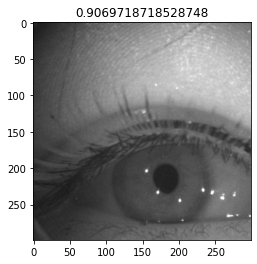

In [ ]:
train_dataset2.show(250)

In [ ]:
#Mish - "Mish: A Self Regularized Non-Monotonic Neural Activation Function"
#https://arxiv.org/abs/1908.08681v1
#implemented for PyTorch / FastAI by lessw2020 
#github: https://github.com/lessw2020/mish

class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [ ]:
def convert_act_cls(model, layer_type_old, layer_type_new):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_act_cls(module, layer_type_old, layer_type_new)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = layer_type_new
            model._modules[name] = layer_new

    return model

Z

In [ ]:
class Squeezenet_regression(nn.Module):

    def __init__(self, arch,ps=0.5):
        super(Squeezenet_regression,self).__init__()
        self.encoder = create_body(arch)        #fastai function that creates an encoder given an architecture
        self.fc1 = create_head(1024,1,ps=ps)

    def forward(self,x):

        x = self.encoder(x)
        label_z = self.fc1(x)

        return [label_z]

In [ ]:
class LossWrapper(nn.Module):
    def __init__(self, task_num):
        super(LossWrapper, self).__init__()
        self.task_num = task_num
        self.log_vars = nn.Parameter(torch.zeros((task_num)))

    def forward(self, preds, label_z):

        mse = MSELossFlat()

        loss2 = mse(preds[0], label_z)

        precision2 = torch.exp(-self.log_vars[0])
        loss2 = precision2*loss2 + self.log_vars[0]
        
        return loss2

In [ ]:
def rmse_z(preds, label_z): return root_mean_squared_error(preds[0], label_z)
metrics = [rmse_z]

In [ ]:
model = Squeezenet_regression(models.squeezenet1_1, ps=0.25)

loss_func = LossWrapper(3).to(data2.device) #just making sure the loss is on the gpu

learn2 = Learner(data2, model, loss_func=loss_func, callback_fns=ShowGraph, metrics=metrics)

learn2.model = convert_act_cls(learn2.model, nn.ReLU, Mish())

#splitting the model so that I can use discriminative learning rates
#learn.split([learn.model.encoder[:6], learn.model.encoder[6:], nn.ModuleList([learn.model.fc1, learn.model.fc2, learn.model.fc3])]);

#first I'll train only the last layer group (the heads)
#learn.freeze()

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-f364aa15.pth


In [ ]:
torch.cuda.get_device_name()
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)

In [ ]:
print(model)

Squeezenet_regression(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): Mish()
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): Mish()
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): Mish()
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): Mish()
      )
      (4): Fire(
        (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): Mish()
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): Mish()
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): Mish()
      )
      (5): MaxPool2d(kernel_size=

epoch,train_loss,valid_loss,rmse_z,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02
Min loss divided by 10: 3.98E-03


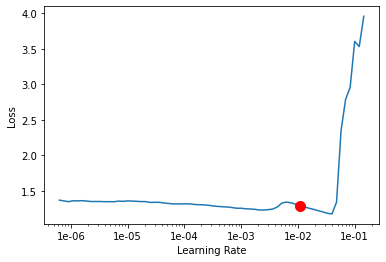

In [ ]:
learn2.lr_find()
learn2.recorder.plot(suggestion = True)

epoch,train_loss,valid_loss,rmse_z,time
0,0.013844,0.006547,0.080717,4:13:56
1,0.000839,0.000643,0.025298,3:11:21


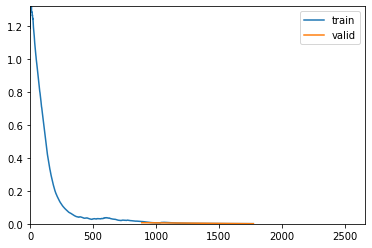

Better model found at epoch 0 with valid_loss value: 0.006547118537127972.
Better model found at epoch 1 with valid_loss value: 0.0006431597284972668.


In [ ]:
learn2.fit_one_cycle(3,max_lr=1e-2, callbacks=[callbacks.SaveModelCallback(learn2, every='improvement', monitor='valid_loss', name='stage-1')])

In [ ]:
learn2 = learn2.load("stage-1")


epoch,train_loss,valid_loss,rmse_z,time
0,0.000160,0.000265,0.016224,4:17:20


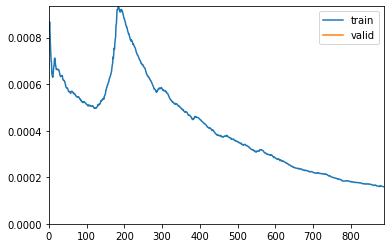

Better model found at epoch 0 with valid_loss value: 0.0002652531547937542.


In [ ]:
learn2.fit_one_cycle(1,max_lr=1e-2, callbacks=[callbacks.SaveModelCallback(learn2, every='improvement', monitor='valid_loss', name='stage-1_1')])

INFERENCES

In [ ]:
#squeezenet z
trained_model2 = learn2.model.cpu()
torch.save(trained_model2.state_dict(),"model_params_squeezenet")

In [ ]:
#squeezenet predictor z
class EyeGazePredictorz():
    def __init__(self, model):
        self.model = model
        self.tfms = get_transforms(do_flip=False,flip_vert=False,max_zoom=1.05,max_warp=0)[1]
        self.norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #imagenet stats

    def predict(self,x):
        #x is a PIL Image
        x = Image(pil2tensor(x, dtype=np.float32).div_(255))
        x = x.apply_tfms(self.tfms, size = 227)
        x = self.norm(x.data)
        preds = self.model(x.unsqueeze(0))
        label_z = torch.exp(preds[0]).item()
        return label_z

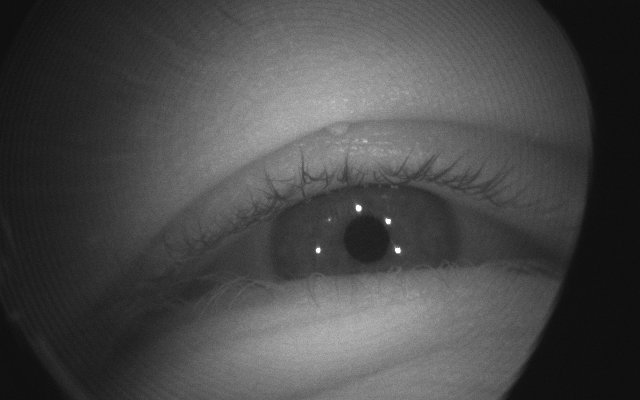

In [ ]:
idx = 200
data_dir = '/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/validation/sequences/'
seq_id,filename = df1.unique_id.iloc[idx].split('_')
img_path = os.path.join(data_dir+'/'+seq_id,filename)
img = PIL.Image.open(img_path).convert('RGB')
img 

In [ ]:
#inception predictor
eyegaze_predictor2 = EyeGazePredictorz(trained_model2)

In [ ]:
print(eyegaze_predictor2.predict(img))

2.5223076343536377


In [ ]:
df1.iloc[idx]

unique_id    7966_044.png
x               0.0941754
y              -0.0267281
z                0.995197
Name: 200, dtype: object

accuracy

In [ ]:
GazeX = eyegaze_predictor.predict(img)[0]
GazeY = eyegaze_predictor.predict(img)[1]
Z = eyegaze_predictor2.predict(img)
GT_x = df1.iloc[idx].x
GT_y = df1.iloc[idx].y
xpixels = 0
ypixels = 0
offset = 0
mu = 0.28

In [ ]:
OSD = mu * math.sqrt(pow((GazeX - xpixels/2),2) + pow((ypixels - GazeY + offset),2))
gazeangle = math.atan(OSD/Z)
EGP = math.sqrt(pow(GazeX, 2) + pow(GazeY, 2) + pow(Z, 2))
pix_dist = math.sqrt(pow((GT_x - GazeX), 2) + pow((GT_y - GazeY), 2))
angacc = (mu * pix_dist * (pow(math.cos(gazeangle), 2)))/EGP
print(OSD, EGP)
print(angacc, math.degrees(angacc))

In [ ]:
from tqdm import tqdm

data_dir = '/content/drive/My Drive/FYP/Dataset/entire/openEDS2020-GazePrediction/validation/sequences/'
eyegaze_predictor = EyeGazePredictorz(trained_model2)
avg_angacc = 0
f = open('/content/drive/MyDrive/FYP/Notebooks/z.txt','a')
for idx in tqdm(range(len(df1))):
  seq_id,filename = df1.unique_id.iloc[idx].split('_')
  img_path = os.path.join(data_dir+'/'+seq_id,filename)
  img = PIL.Image.open(img_path).convert('RGB')
  #print(eyegaze_predictor.predict(img))
  Z = eyegaze_predictor2.predict(img)
  f.write(str(Z))
  f.write('\n')

f.close()

Streaming output truncated to the last 5000 lines.

 84%|████████▍ | 25185/30012 [38:37<07:28, 10.77it/s]

 84%|████████▍ | 25187/30012 [38:37<07:32, 10.67it/s]

 84%|████████▍ | 25189/30012 [38:37<07:26, 10.81it/s]

 84%|████████▍ | 25191/30012 [38:37<07:21, 10.91it/s]

 84%|████████▍ | 25193/30012 [38:37<07:22, 10.89it/s]

 84%|████████▍ | 25195/30012 [38:38<07:20, 10.92it/s]

 84%|████████▍ | 25197/30012 [38:38<07:17, 11.01it/s]

 84%|████████▍ | 25199/30012 [38:38<07:17, 10.99it/s]

 84%|████████▍ | 25201/30012 [38:38<07:21, 10.90it/s]

 84%|████████▍ | 25203/30012 [38:38<07:19, 10.93it/s]

 84%|████████▍ | 25205/30012 [38:39<07:19, 10.94it/s]

 84%|████████▍ | 25207/30012 [38:39<07:21, 10.89it/s]

 84%|████████▍ | 25209/30012 [38:39<07:16, 10.99it/s]

 84%|████████▍ | 25211/30012 [38:39<07:17, 10.99it/s]

 84%|████████▍ | 25213/30012 [38:39<07:17, 10.96it/s]

 84%|████████▍ | 25215/30012 [38:39<07:16, 11.00it/s]

 84%|████████▍ | 25217/30012 [38:40<07:15, 11.02it/s]

 84%|████████

In [ ]:
print(math.degrees(avg_angacc/len(df1)))

7.4784672325806705
